[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


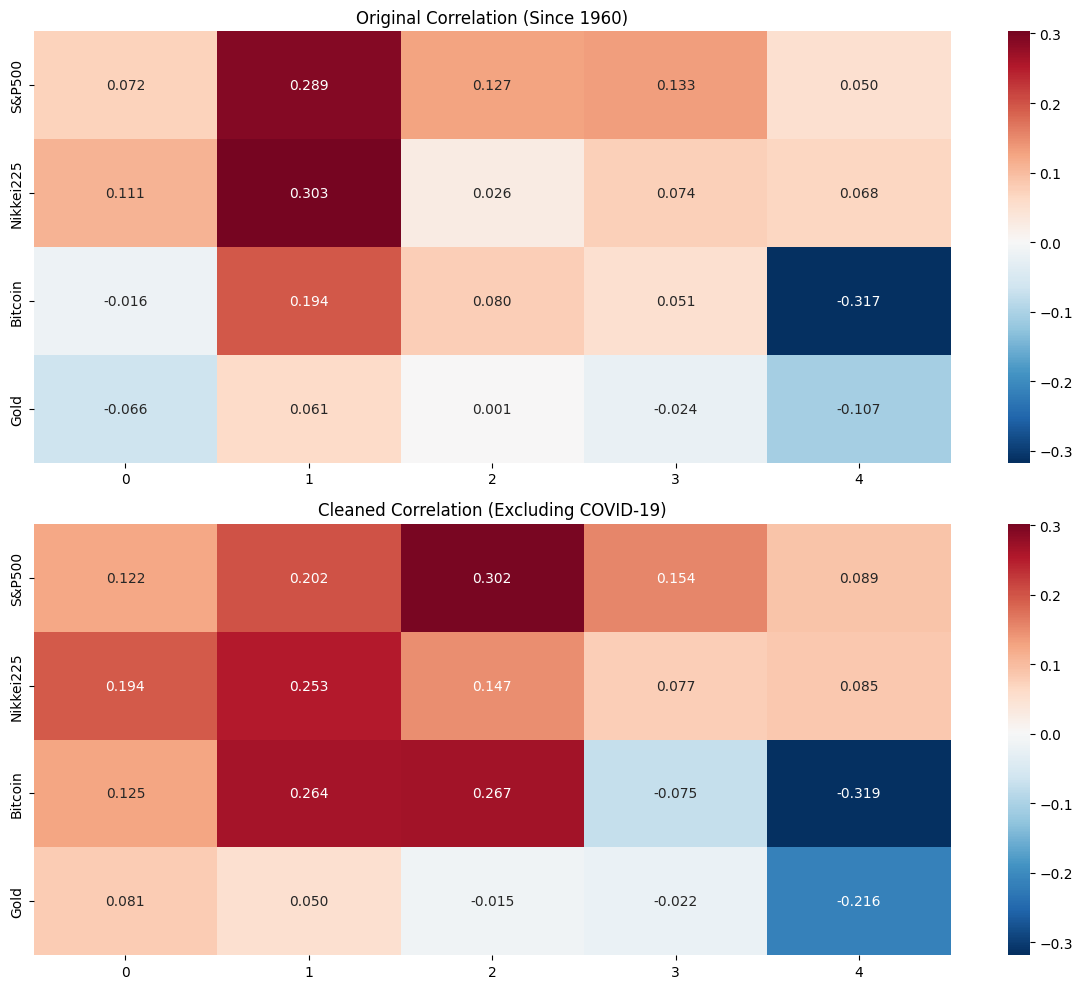

Error: "The following id_vars or value_vars are not present in the DataFrame: ['Date']"


In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# 1. 設定
tickers = {"S&P500": "^GSPC", "Nikkei225": "^N225", "Bitcoin": "BTC-USD", "Gold": "GC=F"}
start, end = "1960-01-01", "2024-12-31"
lags = range(0, 5)
outlier_start, outlier_end = "2020-01-01", "2021-12-31"
rolling_window = 40  # 10年分（40四半期）の窓枠

try:
    gdp = web.DataReader("GDPC1", "fred", start=start, end=end).resample('QS').last()
    gdp_ret = np.log(gdp / gdp.shift(1))

    corr_matrix_raw = pd.DataFrame()
    corr_matrix_clean = pd.DataFrame()
    
    # ローリング相関保存用
    rolling_results = pd.DataFrame()

    for name, ticker in tickers.items():
        price = yf.download(ticker, start=start, end=end)["Close"]
        price_q = price.resample('QS').last()
        price_ret = np.log(price_q / price_q.shift(1))
        
        temp_df = pd.concat([price_ret, gdp_ret], axis=1)
        temp_df.columns = ['Asset', 'GDP']
        
        # --- ヒートマップ用計算 ---
        corrs_raw = [temp_df['Asset'].corr(temp_df['GDP'].shift(-l)) for l in lags]
        corr_matrix_raw[name] = corrs_raw
        
        temp_df_clean = temp_df[(temp_df.index < outlier_start) | (temp_df.index > outlier_end)]
        corrs_clean = [temp_df_clean['Asset'].corr(temp_df_clean['GDP'].shift(-l)) for l in lags]
        corr_matrix_clean[name] = corrs_clean

        # --- ローリング相関の計算 (Lag 1: 3ヶ月先予測を対象) ---
        # コロナ除外済みデータを使用
        rolling_corr = temp_df_clean['Asset'].rolling(window=rolling_window).corr(temp_df_clean['GDP'].shift(-1))
        rolling_results[name] = rolling_corr

    # 3. ヒートマップの表示
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    sns.heatmap(corr_matrix_raw.T, annot=True, cmap='RdBu_r', center=0, fmt=".3f", ax=ax1)
    ax1.set_title("Original Correlation (Since 1960)")
    sns.heatmap(corr_matrix_clean.T, annot=True, cmap='RdBu_r', center=0, fmt=".3f", ax=ax2)
    ax2.set_title("Cleaned Correlation (Excluding COVID-19)")
    plt.tight_layout()
    plt.show()

    # 4. ローリング相関の可視化 (Plotly)
    # データの形式をPlotly用に変換
    rolling_plot_df = rolling_results.reset_index().melt(id_vars='Date', var_name='Ticker', value_name='Correlation')
    
    fig_roll = px.line(
        rolling_plot_df.dropna(), 
        x="Date", y="Correlation", color="Ticker",
        title=f"Historical Change in Correlation (Lag 1, {rolling_window}Q Rolling Window)",
        labels={"Correlation": "Corr with Future GDP", "Date": "Year"},
        template="plotly_dark"
    )
    fig_roll.add_hline(y=0, line_dash="dash", line_color="gray") # 0の基準線
    fig_roll.show()

except Exception as e:
    print(f"Error: {e}")